## generative model / discriminative model 

- 产生式模型：用来估计联合概率 $P(x,y)$, 因此可以根据联合概率来生成样本，如 HMM
- 判别式模型：用来估计条件概率 $P(y|x)$, 因为没有 $x$ 的知识（$P(x)?$），无法生成样本，只能判断分类
- case
    - `(1,0), (1,0), (2,0), (2,1)`
        - $P(x,y)$: 
            - $\sum_{x,y}P(x,y)=1$
            - $P(1, 0) = 1/2, P(1, 1) = 0, P(2, 0)= 1/4, P(2, 1) = 1/4$.
        - $P(y|x)$
            - $\sum_yP(y|x)=1$
            - $P(0|1) = 1, P(1|1) = 0$
            - $P(0|2) =1/2, P(1|2) = 1/2$

## EBM => RBM

- 参考
    - https://odie2630463.github.io/2021/06/01/ebm-1/
    - https://www.bilibili.com/video/BV1Bh411r7k9/
- EBM
    - 能量函数的输出是一个实数值（scalar），能量函数越小表示可能性越高，能量函数用来衡量变量的可能性
- 一般的 model 到 EBM
    - 一般的 model：
$$
y=f_W(x)
$$
    - energy base model
        - $E$ 是一个 scalar，是一个值，$x$ 与 $y$ 匹配时 $E$ 较小（-1），$x$ 与 $y$ 不匹配时 $E$ 较大（1）；
        - 因此 learning 的过程是一个最小化 $E$ 的过程，也就是让 $y$ 与 $x$ 尽可能匹配的过程；
$$
E=f_W(x,y)
$$

- EBM 的应用
    - 分类：（一个直观的理解，遍历所有的 $y$，真正的 $y$ 是那些使得 $E$ 最小的 $y$
$$
y=\arg\min_yf_W(x,y)\\
y=y+\epsilon\frac{\partial E}{\partial y}
$$
    - 生成

$$
xy=\arg\min_{xy}f_W(x,y)\\
x=\arg\min_xf_W(x,y)
$$

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import sleep

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### dataloader

In [4]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data', train=True, download=True, 
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor()
                               ])),
    shuffle=True, batch_size=64, drop_last=True)

In [13]:
# 937*64
# 60000//64
len(train_loader)

937

In [9]:
x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [10]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

In [11]:
x, y = next(iter(cycle(train_loader)))
print(x.shape, y.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [26]:
train_iterator = iter(cycle(train_loader))

In [17]:
train_loader.dataset[0][0].clamp(0,1).repeat(3,1,1).shape

torch.Size([3, 28, 28])

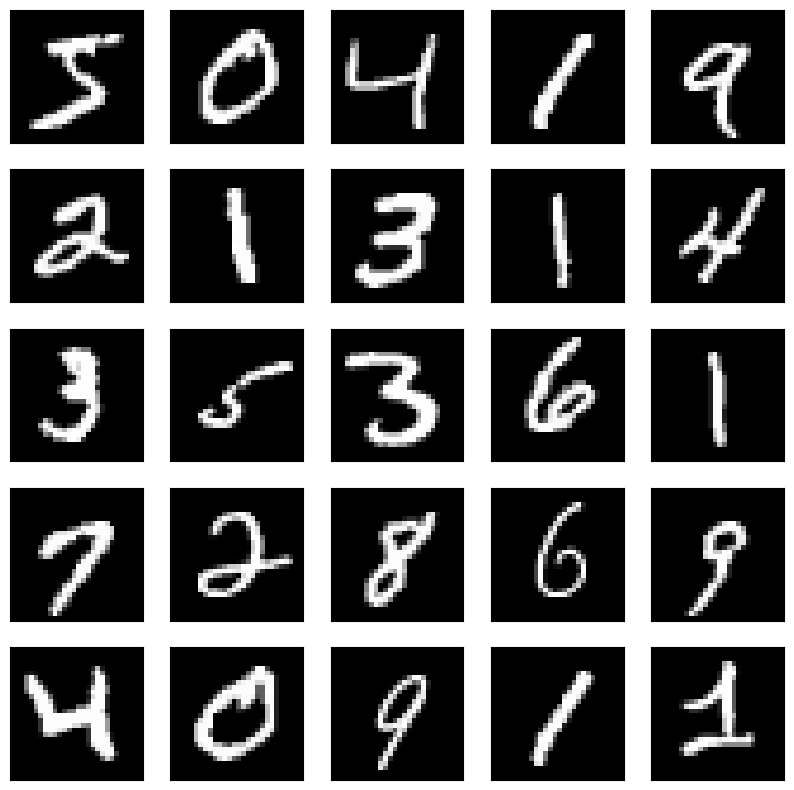

In [22]:
n_channels = 1
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if n_channels == 1:
        plt.imshow(train_loader.dataset[i][0].clamp(0,1).repeat(3,1,1).permute(1,2,0), 
                   cmap=plt.cm.binary)

## RBM

In [23]:
# architecture and code from Odie Ko
class RBM(nn.Module):
    def __init__(self, n_vis=784, n_hin=500, k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis).to(device)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis).to(device))
        self.h_bias = nn.Parameter(torch.zeros(n_hin).to(device))
        self.k = k
    
    def sample_from_p(self,p):
        # samples are conditionally independeant, so we can sample from univariate random variables
        return F.relu(torch.sign(p - (torch.rand(p.size()).to(device))))
    
    def v_to_h(self,v):
        p_h = torch.sigmoid(F.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
    def h_to_v(self,h):
        p_v = torch.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
    def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k): # MCMC approximation, in practice k=1 is used
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_
    
    def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

R = RBM(k=1).to(device)
print(f'> Number of RBM parameters {len(torch.nn.utils.parameters_to_vector(R.parameters()))}')

# initialise the optimiser
optimiser = torch.optim.Adam(R.parameters(), lr=0.0002, betas=(0.5, 0.999))
epoch = 0

> Number of RBM parameters 393284


loss: -9.298


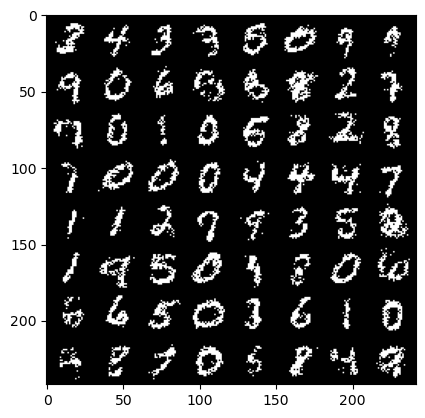

loss: -9.057


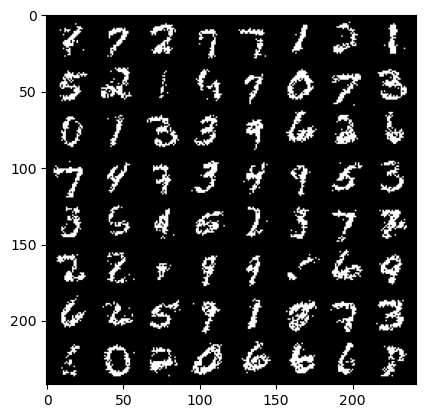

loss: -8.660


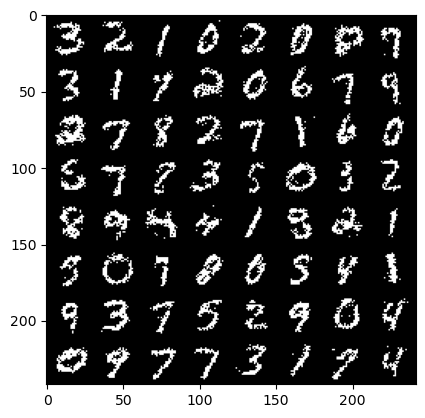

loss: -8.522


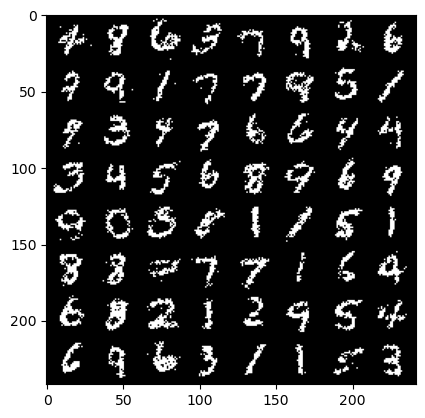

loss: -8.379


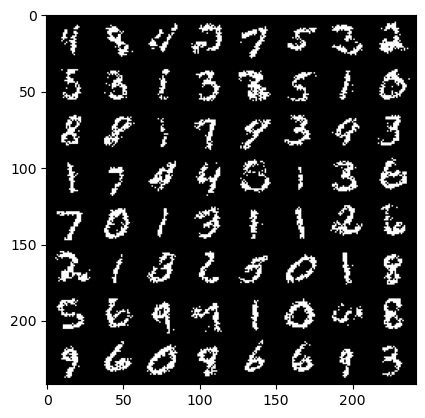

loss: -7.982


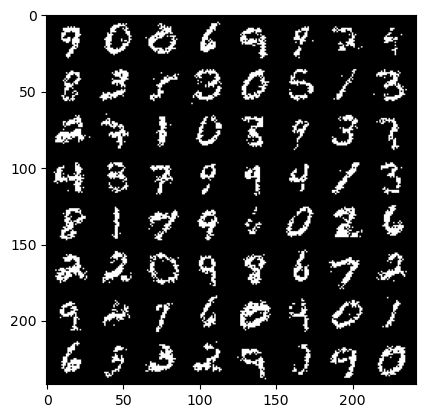

loss: -7.757


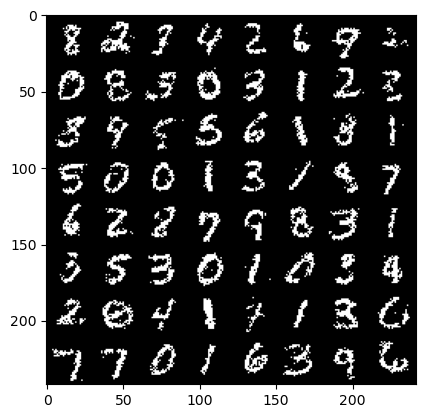

loss: -7.735


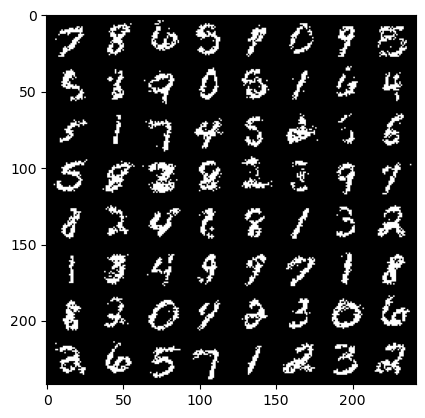

loss: -7.386


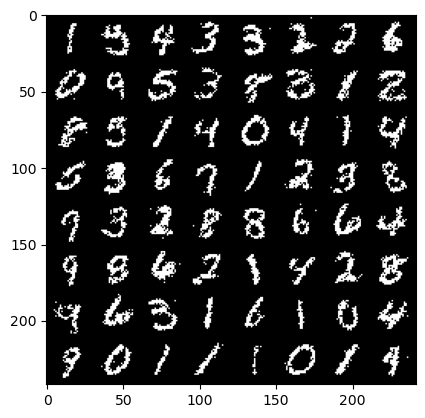

loss: -7.283


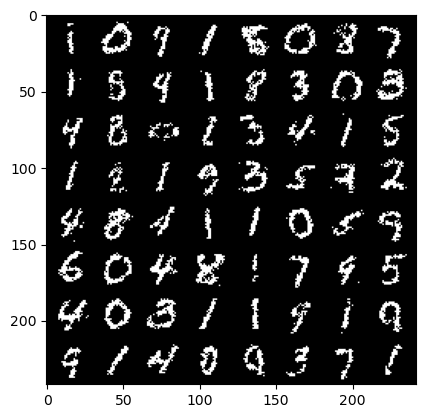

loss: -6.983


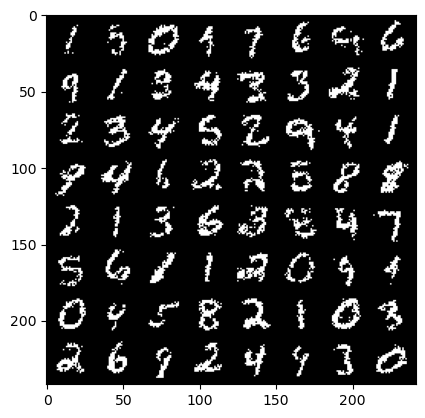

loss: -6.745


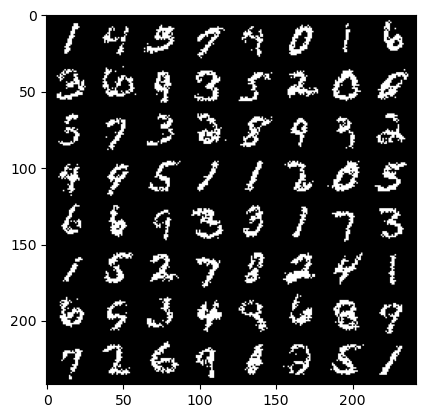

loss: -6.641


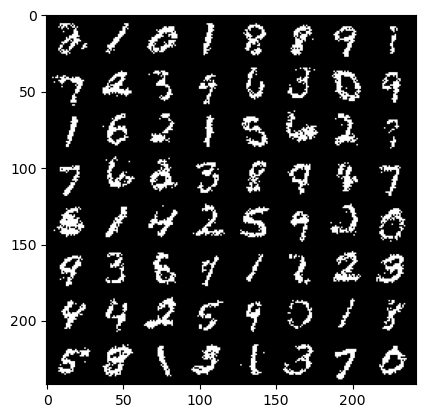

loss: -6.440


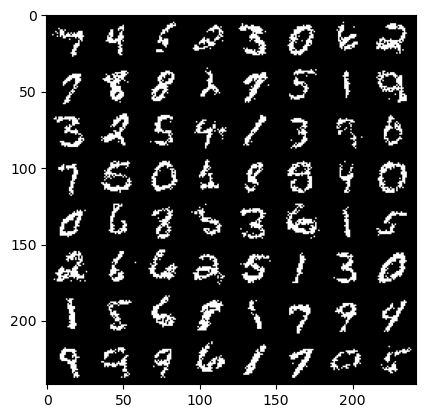

loss: -6.419


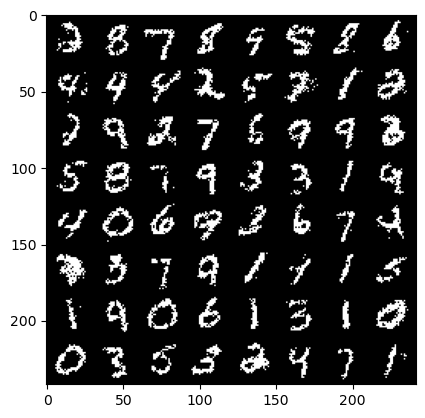

loss: -6.189


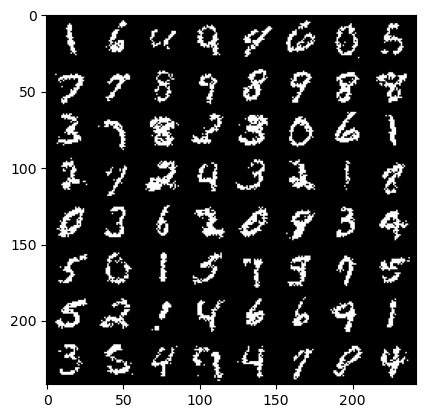

loss: -6.061


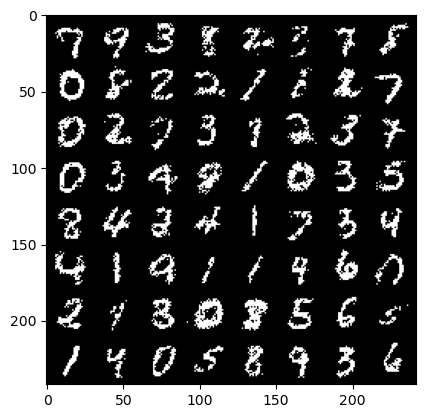

loss: -5.968


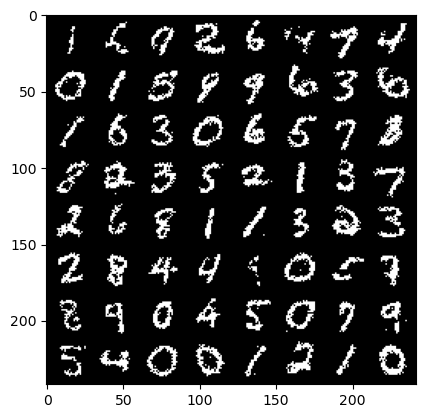

loss: -5.678


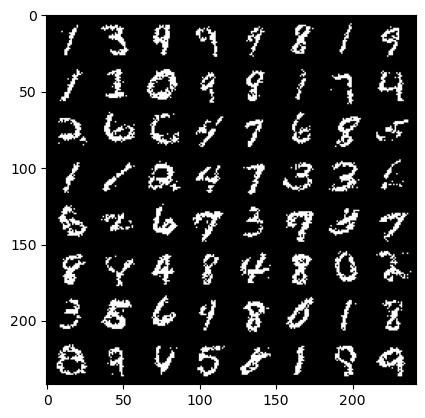

loss: -5.582


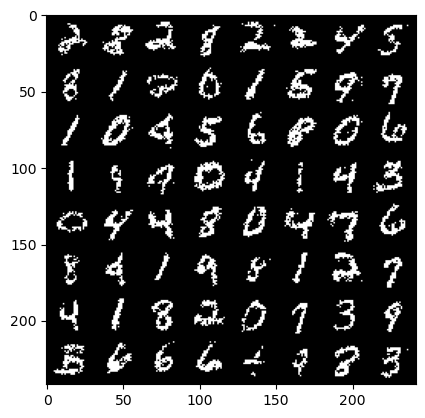

loss: -5.665


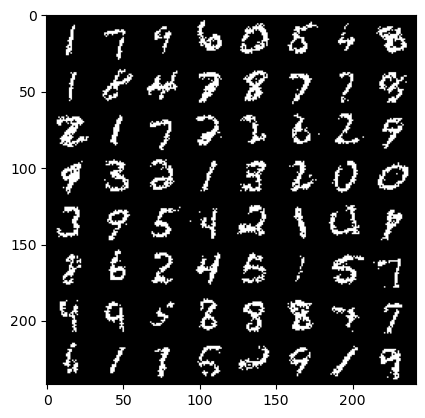

loss: -5.319


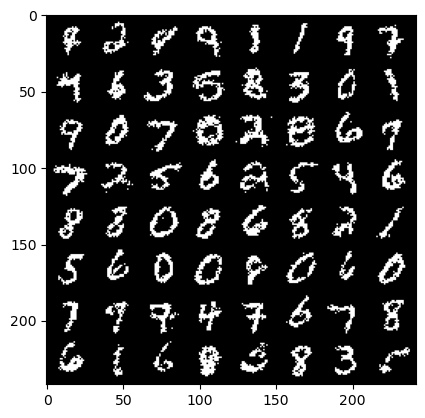

loss: -5.312


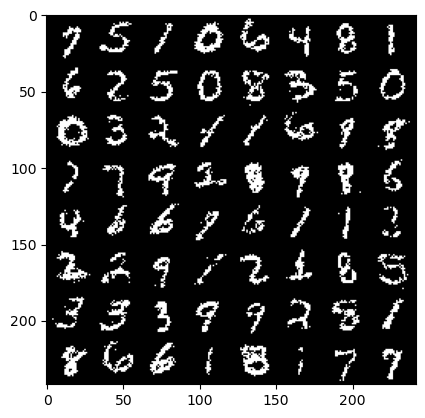

loss: -5.207


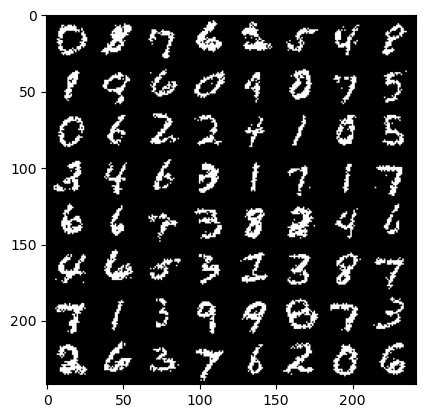

loss: -4.940


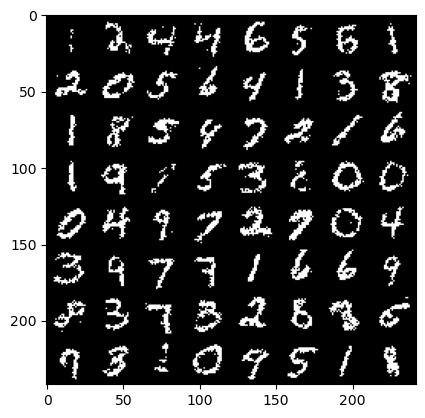

loss: -4.949


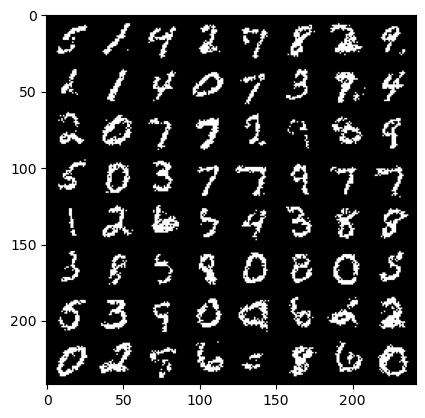

loss: -4.821


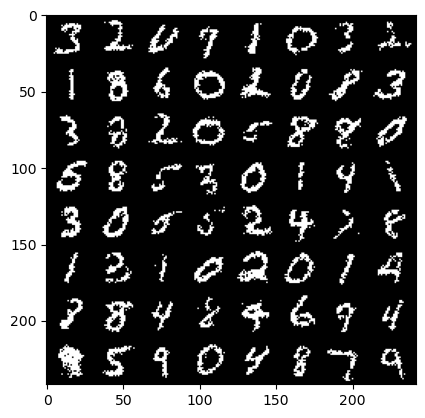

loss: -4.703


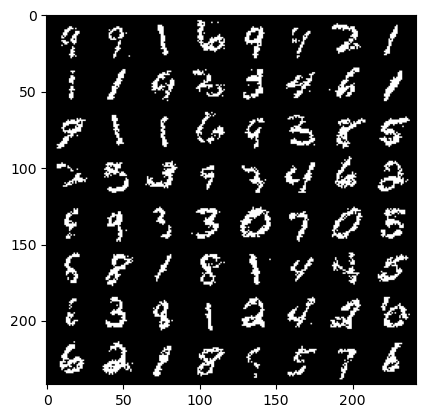

loss: -4.719


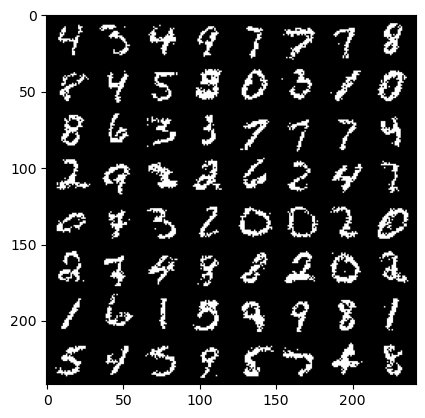

loss: -4.638


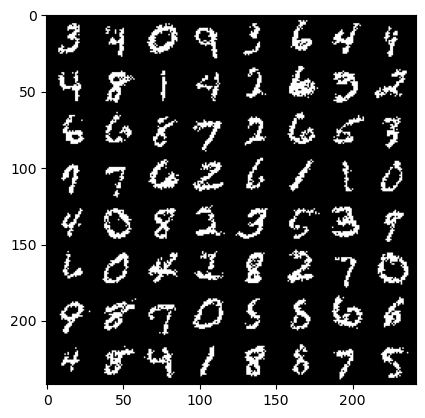

loss: -4.531


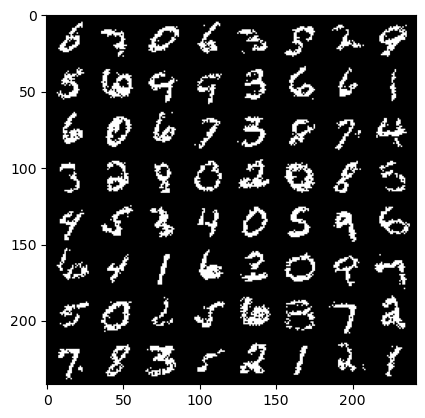

loss: -4.333


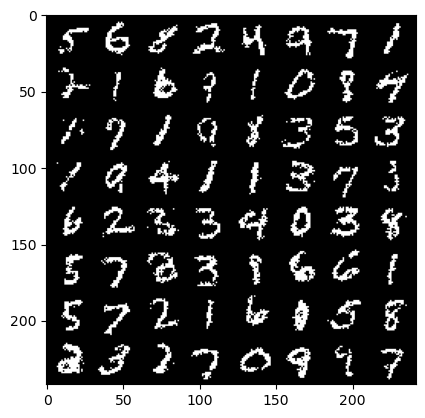

loss: -4.328


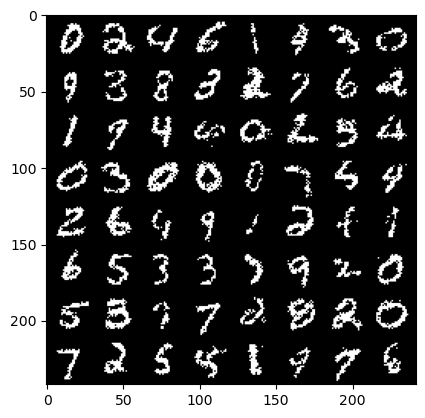

loss: -4.264


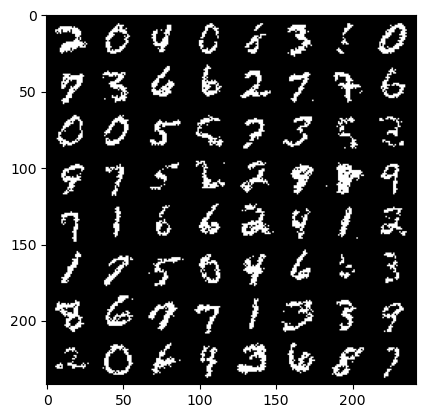

loss: -4.122


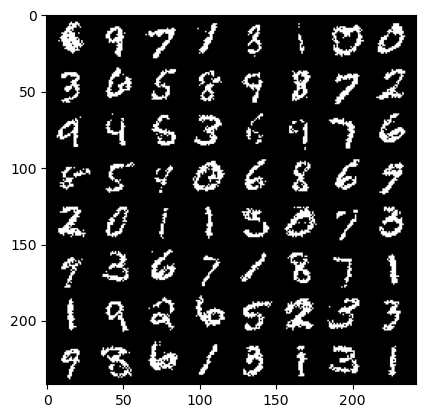

loss: -4.035


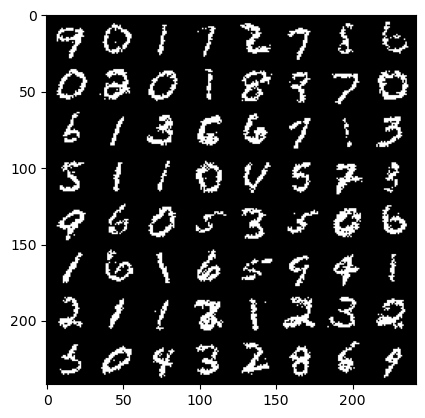

loss: -4.084


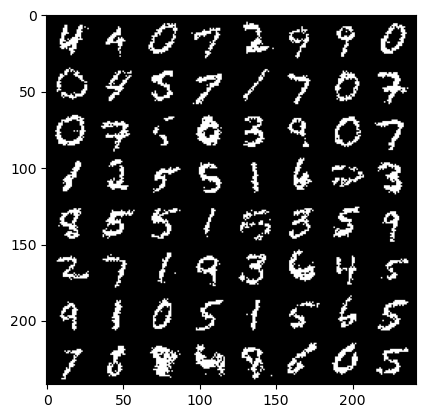

loss: -3.837


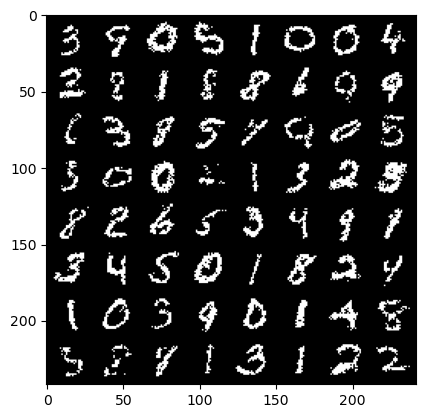

loss: -3.873


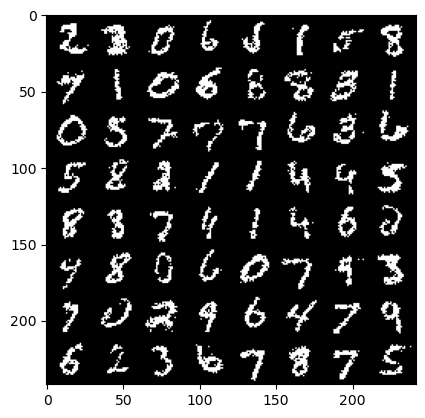

loss: -3.771


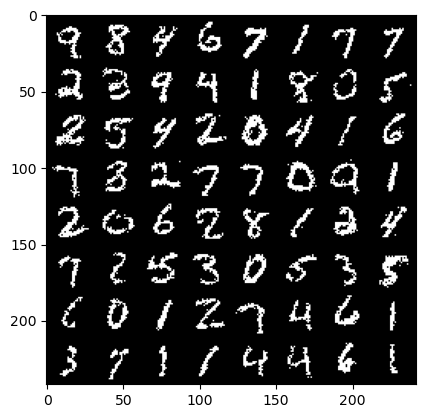

loss: -3.838


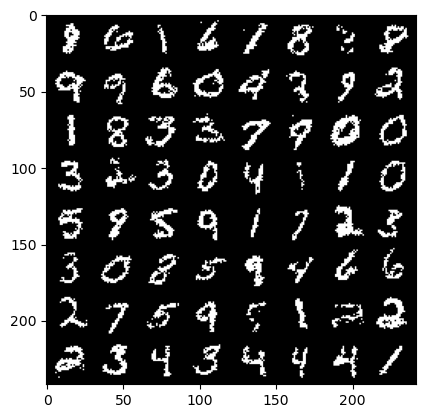

loss: -3.652


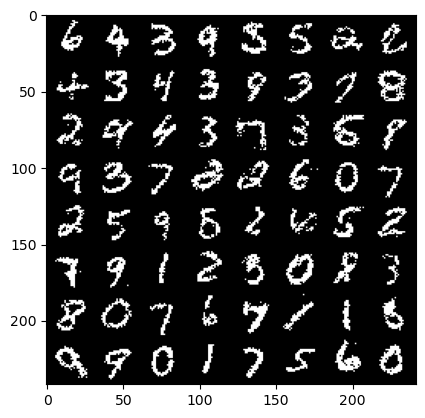

loss: -3.675


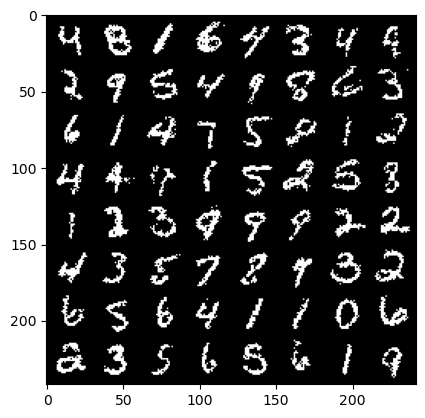

loss: -3.458


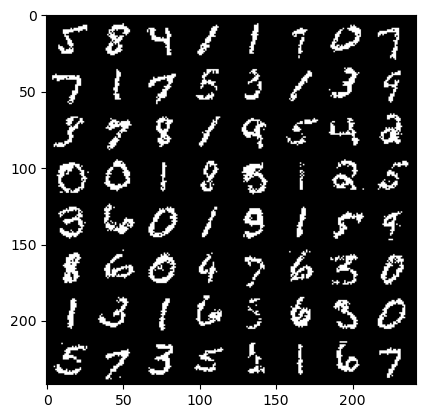

loss: -3.507


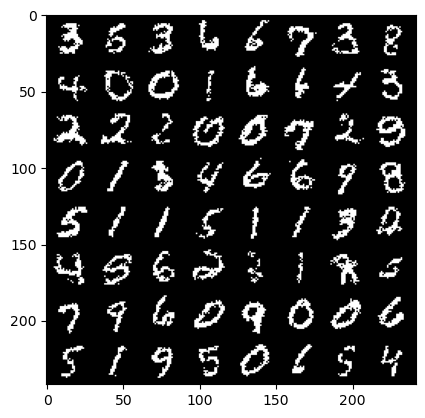

loss: -3.490


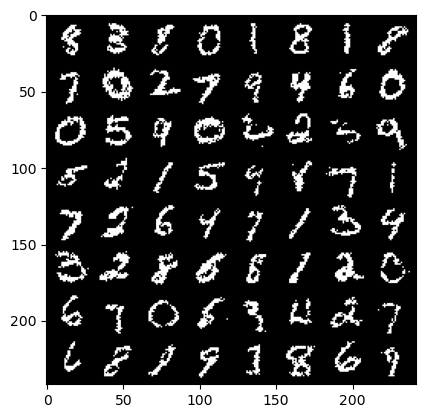

loss: -3.374


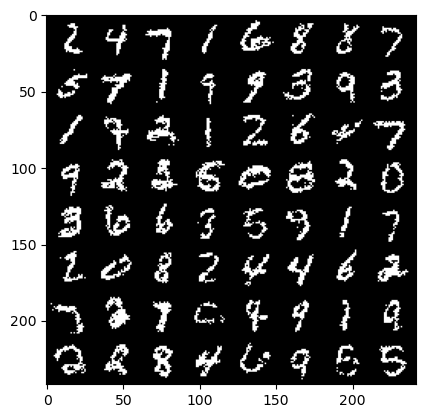

loss: -3.185


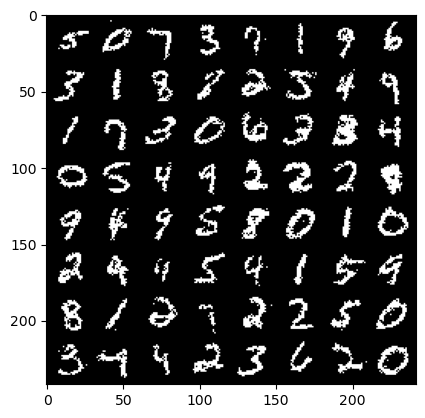

loss: -3.314


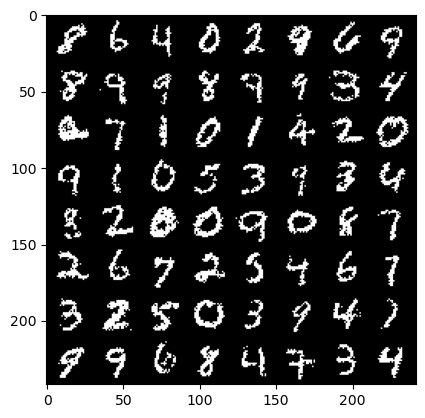

loss: -3.160


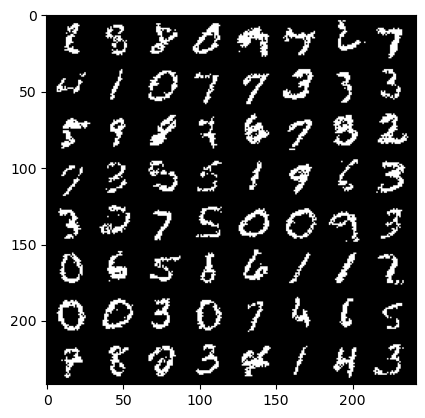

loss: -3.224


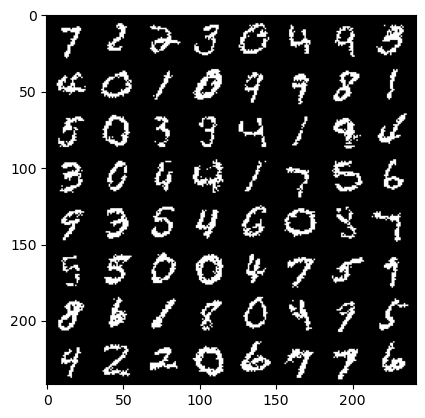

loss: -3.117


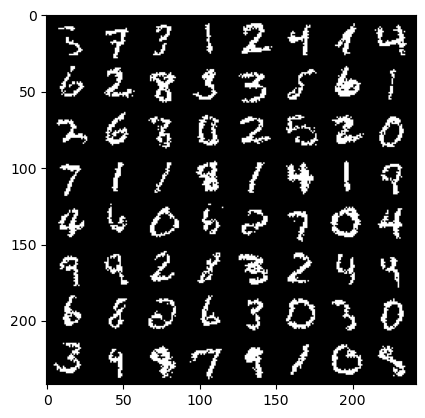

loss: -3.097


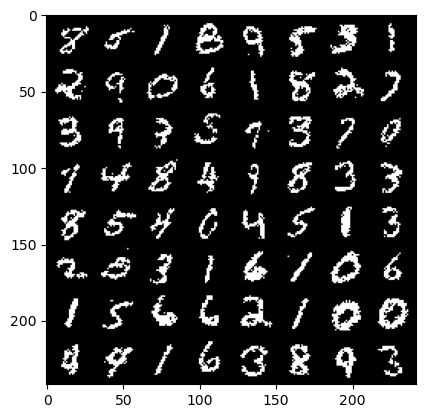

loss: -2.997


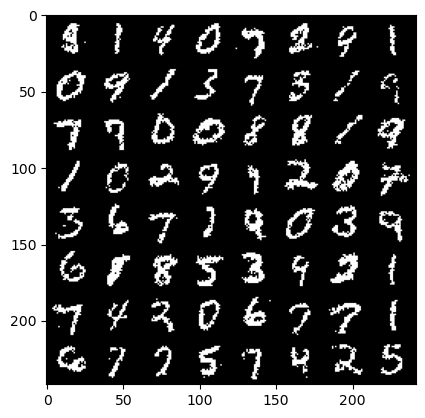

loss: -2.960


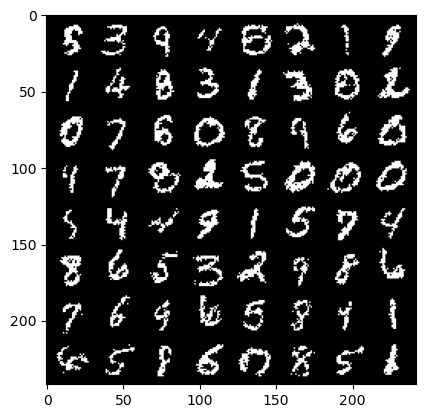

loss: -2.894


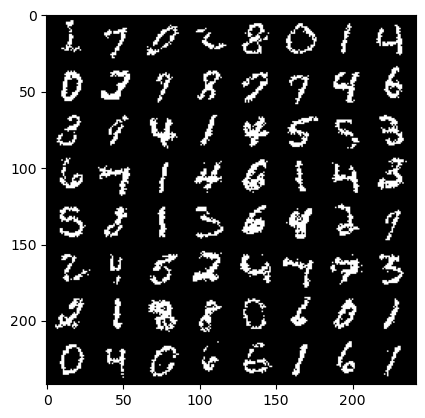

loss: -3.028


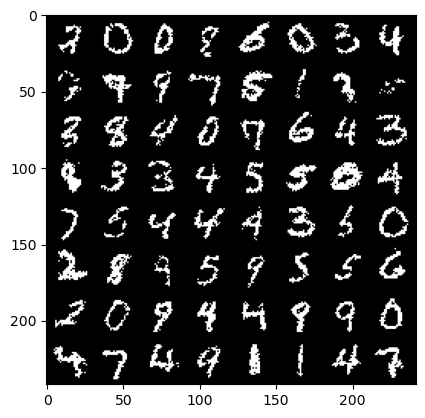

loss: -2.910


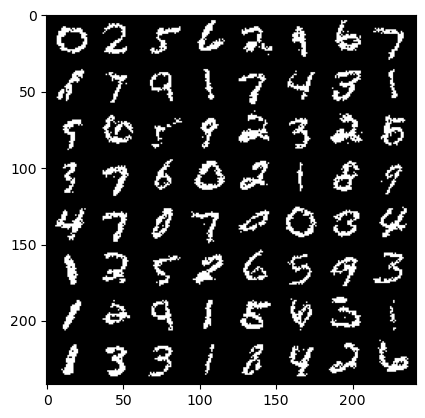

loss: -2.847


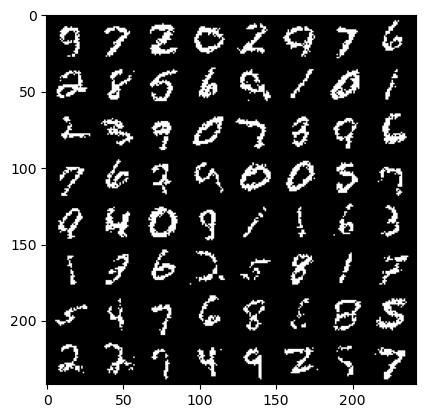

loss: -2.833


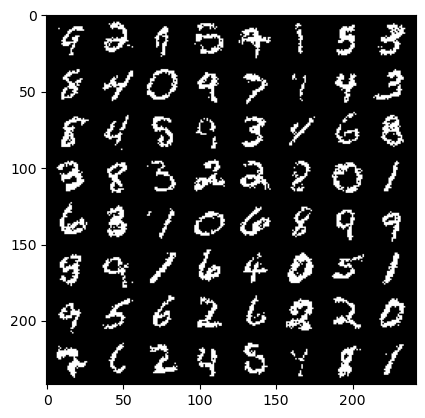

loss: -2.754


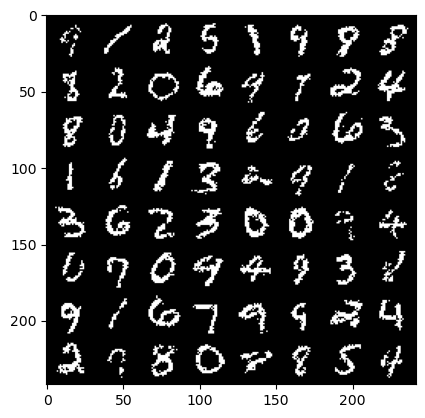

loss: -2.666


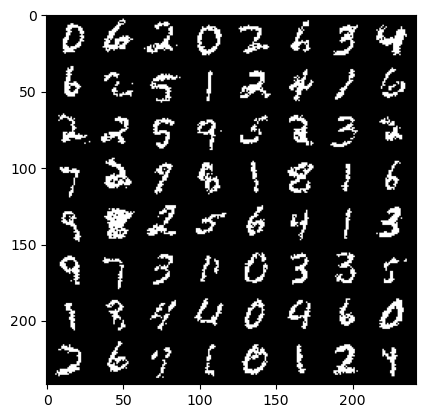

loss: -2.821


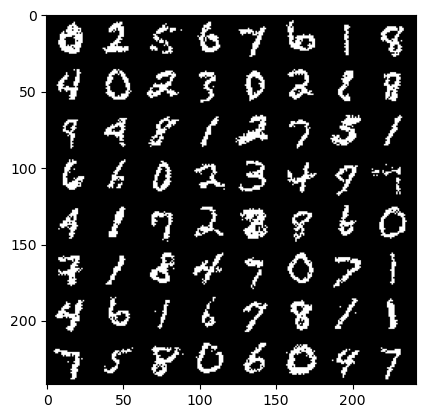

loss: -2.630


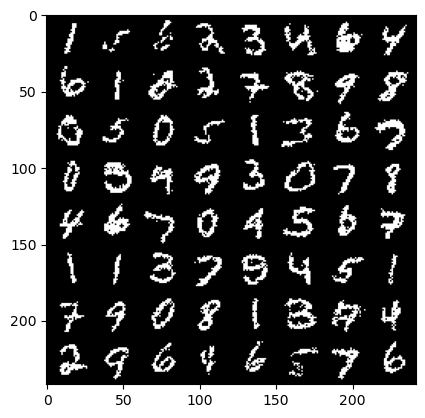

loss: -2.685


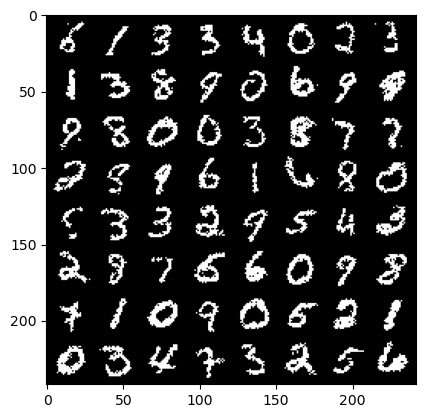

loss: -2.568


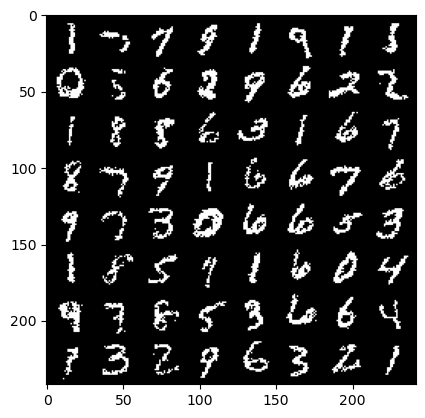

loss: -2.594


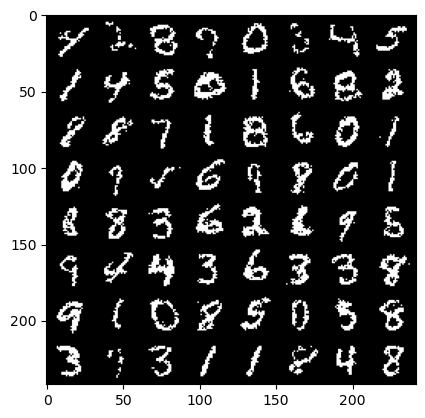

loss: -2.574


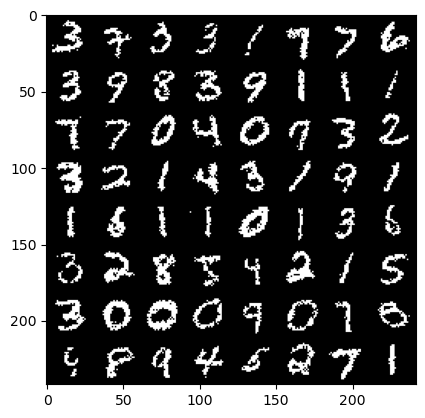

loss: -2.573


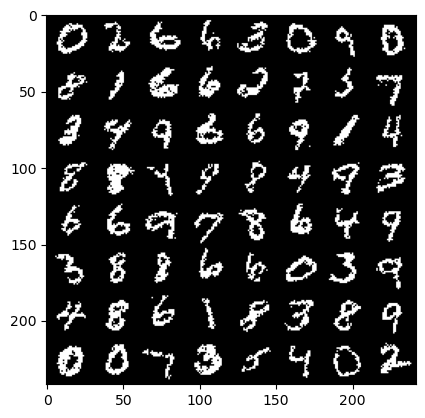

loss: -2.474


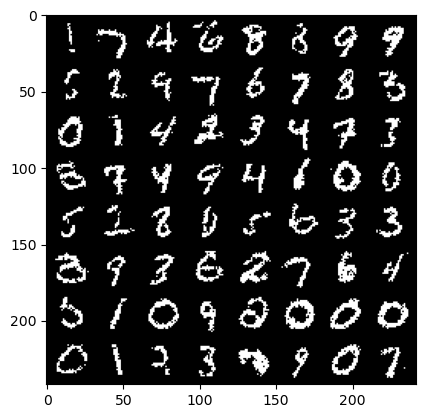

loss: -2.439


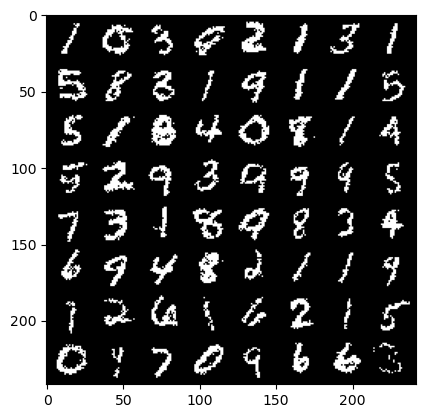

loss: -2.416


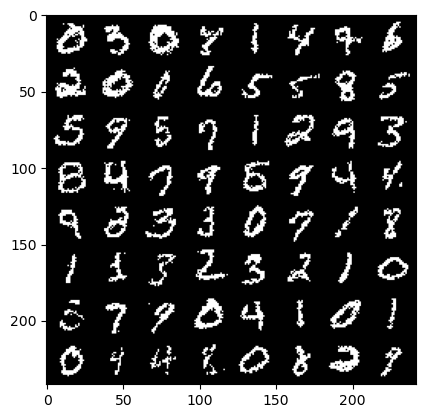

loss: -2.419


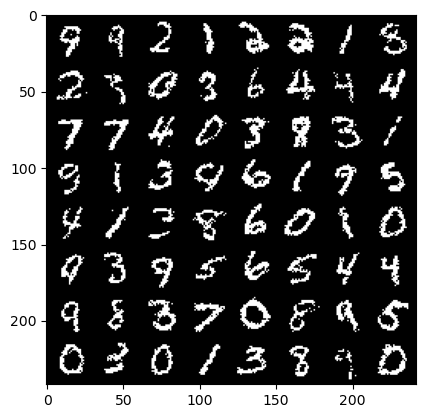

loss: -2.409


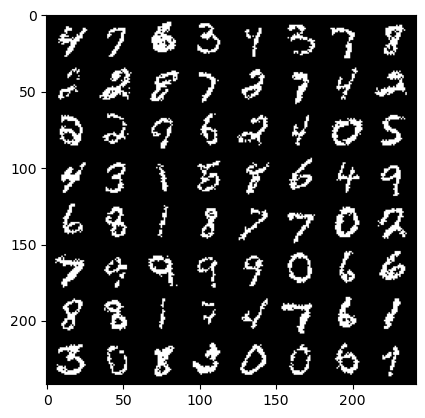

loss: -2.394


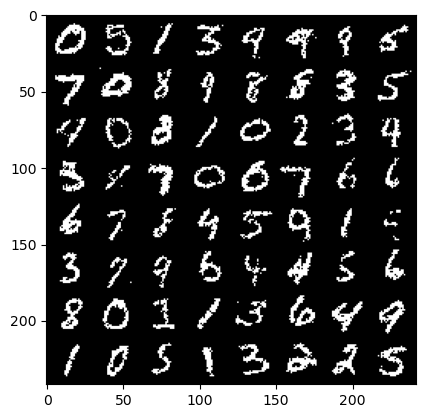

loss: -2.384


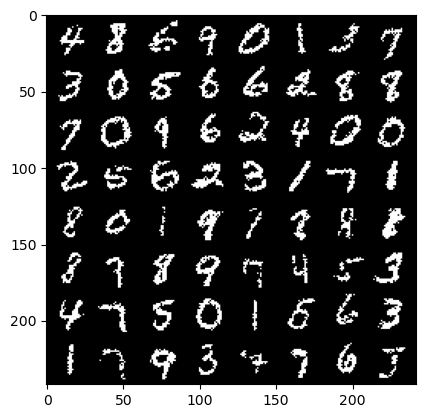

loss: -2.151


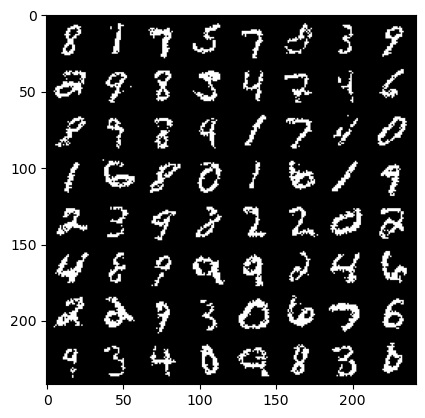

loss: -2.334


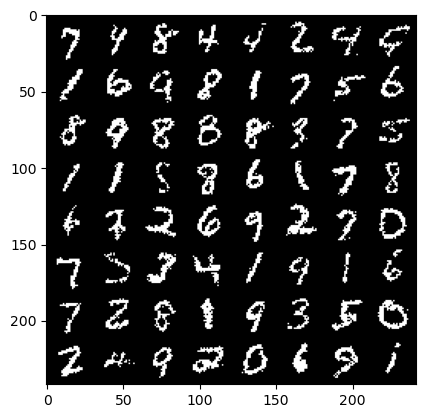

loss: -2.255


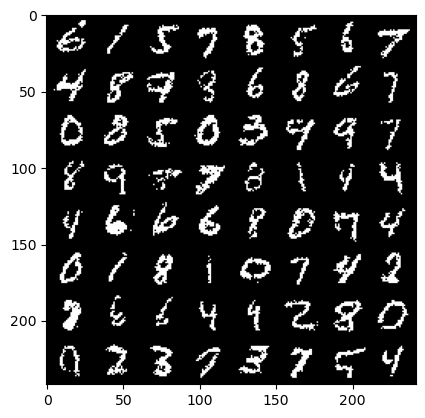

loss: -2.218


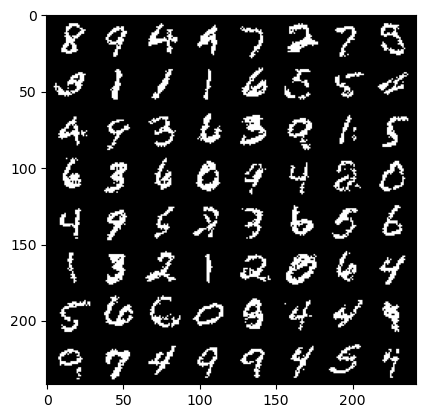

In [28]:
# training loop
while (epoch<100):
    
    # arrays for metrics
    loss_arr = np.zeros(0)

    # iterate over some of the train dateset
    for i in range(500):
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)

        x = x.view(-1,784)
        sample_data = x.bernoulli().to(device)
        
        v,v1 = R(sample_data)
        loss = R.free_energy(v) - R.free_energy(v1)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        loss_arr = np.append(loss_arr, loss.item())

    # plot some examples
    g = v1.view(-1,1,28,28)
    print('loss: {:.3f}'.format(loss_arr.mean()))
    plt.grid(False)
    plt.imshow(torchvision.utils.make_grid(g).cpu().data.clamp(0,1).permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.show()
    plt.pause(0.0001)

    epoch = epoch+1